<a href="https://colab.research.google.com/github/alik604/dimensionality-reduction-overview/blob/master/KDD_quick_as_possible_%2B_with_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intrusion Detection 

### Dataset from https://github.com/defcom17/NSL_KDD/
* [more info](https://docs.google.com/spreadsheets/d/1oAx320Vo9Z6HrBrL6BcfLH6sh2zIk9EKCv2OlaMGmwY/edit#gid=0)

### Sample code used: https://www.kaggle.com/meesterwaffles/nicholas-brougher-neb5211-project4


In [0]:
%config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np
import re
import sklearn

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib as matplot
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from keras.models import Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,normalize

In [0]:
labels = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
'num_access_files', 'num_outbound_cmds', 'is_host_login',
'is_guest_login', 'count', 'srv_count', 'serror_rate',
'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate', 'attack_type', 'difficulty_level']# subclass - > attack_type

train = pd.read_csv('https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.csv')
test = pd.read_csv('https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.csv')
train.columns , test.columns = labels , labels
combined_data = pd.concat([train, test]).drop('difficulty_level', 1)
# combined_data.shape
# combined_data.head(5)

### The following few cells are taken from the 'sample code'

In [250]:
le = LabelEncoder()

vector = combined_data['attack_type']

print("Attack Vectors:", set(list(vector))) # use print to make it print on single line 
combined_data['attack_type'] = le.fit_transform(vector)
combined_data['protocol_type'] = le.fit_transform(combined_data['protocol_type'])
combined_data['service'] = le.fit_transform(combined_data['service'])
combined_data['flag'] = le.fit_transform(combined_data['flag'])

print('\nDescribing attack_type: ')
print("min", vector.min())
print("max", vector.max())
print("mode",vector.mode())
print("mode", len(np.where(vector.values==16)[0])/len(vector),"%")
print("looks like 16 is 'normal' ")

Attack Vectors: {'land', 'back', 'sendmail', 'named', 'sqlattack', 'worm', 'spy', 'imap', 'normal', 'xsnoop', 'satan', 'loadmodule', 'saint', 'ftp_write', 'buffer_overflow', 'portsweep', 'rootkit', 'apache2', 'guess_passwd', 'pod', 'warezmaster', 'smurf', 'processtable', 'phf', 'neptune', 'ipsweep', 'multihop', 'mscan', 'snmpguess', 'nmap', 'snmpgetattack', 'httptunnel', 'xlock', 'perl', 'ps', 'teardrop', 'mailbomb', 'xterm', 'udpstorm', 'warezclient'}

Describing attack_type: 
min apache2
max xterm
mode 0    normal
dtype: object
mode 0.0 %
looks like 16 is 'normal' 


# Reduce feature space - unused

In [0]:
def RFS(): 
  # select least correlated
  corr_matrix = combined_data.corr().abs().sort_values('attack_type')
  # tmp.head(10) # to view CORR matrix 
  leastCorrelated = corr_matrix['attack_type'].where(lambda x: x < 0.005).dropna()
  leastCorrelated = list(leastCorrelated.index)

  # select least STD
  leastSTD = combined_data.std().to_frame().where(lambda x: x < 0.05).dropna()#.nsmallest(20, columns=0)
  leastSTD = list(leastSTD.transpose().columns)

  featureElimination = set(leastCorrelated + leastSTD)
  return featureElimination

# featureElimination = RFS()
# len(featureElimination)
# featureElimination




# Drop features and preform train_test_split

In [0]:
# combined_data_reduced = combined_data.drop(featureElimination,axis=1)

data_x = combined_data.drop('attack_type', axis=1)
data_y = combined_data.loc[:,['attack_type']]
# del combined_data # free mem
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=.5, random_state=42) # TODO

X_train = pd.DataFrame(normalize(X_train))
X_test = pd.DataFrame(normalize(X_test))

# Basline ML 

In [253]:
import gc 
_ = gc.collect()
print("# of Dims, ",X_train.shape[1])

# of Dims,  41


In [0]:
DTC = DecisionTreeClassifier() 
RFC = RandomForestClassifier(n_estimators=25, random_state=1)
ETC = ExtraTreesClassifier(n_estimators=10, criterion='gini', max_features='auto', bootstrap=False)
x = X_train
y = y_train['attack_type'].ravel()

eclf = VotingClassifier(estimators=[('lr', DTC), ('rf', RFC),('et',ETC)], voting='hard') 
# for clf, label in zip([DTC, RFC,ETC, eclf], ['DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'Ensemble']): 
#     _ = clf.fit(x,y)
#     pred = clf.score(X_test,y_test)
#     print("Acc: %0.10f [%s]" % (pred,label))

# Comparison

In [0]:
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.svm import LinearSVC
n = 30 

In [256]:
rfe = RFE(DTC, n).fit(x,y)

desiredIndices = np.where(rfe.support_==True)[0]
whitelist = X_train.columns.values[desiredIndices]
X_train_RFE,X_test_RFE = X_train[whitelist],X_test[whitelist]


eclf = VotingClassifier(estimators=[('DecisionTreeClassifier', DTC), ('RandomForestClassifier', RFC),('ExtraTreesClassifier',ETC)], voting='hard')
_ = eclf.fit(X_train_RFE,y_train)
pred = eclf.score(X_test_RFE,y_test)

print("Acc: %0.10f" % (pred))
print("number of features",X_train_RFE.shape[1])

Acc: 0.9929568930
number of features 30


The above cell shows the tradeoff of garbagings the least useful features

In [257]:
svd = TruncatedSVD(n_components=n-20) 
_ = svd.fit(X_train_RFE)  

X_train_svd, X_test_svd = svd.transform(X_train_RFE), svd.transform(X_test_RFE)

# eclf = VotingClassifier(estimators=[('DecisionTreeClassifier', DTC), ('RandomForestClassifier', RFC),('ExtraTreesClassifier',ETC)], voting='hard')
# _ = eclf.fit(X_train_svd,y_train)

# pred = eclf.score(X_test_svd,y_test)
# print("Acc: %0.10f" % (pred))
# print("number of features",X_train_svd.shape[1])

# print(len(svd.components_) , "components,",len(svd.components_[0]), " length")

'''
Acc: 0.9921219548
number of features 20
----
Acc: 0.9851461815
number of features 10
'''

'\nAcc: 0.9921219548\nnumber of features 20\n----\nAcc: 0.9851461815\nnumber of features 10\n'

# Benchmark post feature reduction

In [258]:
print(X_train_svd.shape)

DTC = DecisionTreeClassifier() 
RFC = RandomForestClassifier(n_estimators=25, random_state=1)
ETC = ExtraTreesClassifier(n_estimators=10, criterion='gini', max_features='auto', bootstrap=False)

eclf = VotingClassifier(estimators=[('lr', DTC), ('rf', RFC),('et',ETC)], voting='hard') 
for clf, label in zip([DTC, RFC,ETC, eclf], ['DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'Ensemble']): 
    _ = eclf.fit(X_train_svd,y_train)
    pred = eclf.score(X_test_svd,y_test)
    print("Acc: %0.10f [%s]" % (pred,label))

(74257, 10)

Acc: 0.9861561873 [DecisionTreeClassifier]
Acc: 0.9861965875 [RandomForestClassifier]
Acc: 0.9859541861 [ExtraTreesClassifier]
Acc: 0.9860215199 [Ensemble]


0.985 for 10 dimensions of data

I like this better than 0.9937110306 with 41 features (dimension)

# Auto Encoder - not working 

In [0]:
gc.collect()
print(X_train.shape)
print(X_test.shape)
# print(X_train_RFE.shape)
# print(X_test_RFE.shape)
# print(X_train_svd.shape) 
# print(X_test_svd.shape)

from sklearn.preprocessing import minmax_scale # 0.59 
from sklearn.preprocessing import StandardScaler # much beter 

735

(74257, 41)
(74257, 41)


In [0]:
data_xx = data_x.copy()
data_xx = StandardScaler().fit_transform(data_xx)
X_train, X_test, y_train, y_test = train_test_split(data_xx, data_y, test_size=.5, random_state=42) # TODO

svd = TruncatedSVD(n_components=20).fit(X_train) 
X_train_svd, X_test_svd = svd.transform(X_train), svd.transform(X_test)

ss =StandardScaler()
X_train_svd= ss.fit_transform(X_train_svd)
X_test_svd = ss.transform(X_test_svd)

In [0]:
#X_train.shape
pd.DataFrame(X_train_svd).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04,7.425700e+04
mean,1.583903e-16,4.838546e-17,6.967507e-17,1.799607e-17,-1.727710e-17,2.939272e-17,1.135117e-16,-1.786162e-16,3.739099e-17,1.124378e-17,5.877180e-18,-7.263239e-17,-4.523452e-17,3.072486e-17,-3.598739e-18,2.174524e-17,4.342544e-18,7.710814e-17,1.420737e-17,4.335367e-17
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00
min,-1.326392e+00,-1.151137e+00,-2.413708e+00,-3.487665e+00,-2.104754e+00,-2.674641e+01,-8.434520e+00,-7.499560e+00,-8.542716e-01,-9.090700e+01,-2.041504e+01,-1.095229e+01,-1.408174e+01,-2.412787e+01,-3.065348e+01,-1.859074e+01,-7.436341e+00,-2.015774e+01,-2.596260e+01,-1.242267e+01
25%,-8.755797e-01,-3.913524e-01,-5.128250e-01,-1.767810e-01,-9.207746e-02,-1.930832e-01,-2.264271e-01,-2.968541e-01,-7.007080e-02,-9.728088e-02,-4.405846e-02,-2.080518e-01,-1.489526e-01,-1.581466e-01,-1.245426e-01,-5.241772e-01,-6.029504e-01,-2.893537e-01,-5.997462e-02,-5.361367e-01
50%,-5.020869e-01,-1.233750e-01,3.230989e-02,6.118127e-02,-3.726681e-02,-1.047378e-01,2.602395e-01,4.433339e-03,-2.832066e-02,-3.282729e-02,2.256750e-02,2.599566e-02,-3.707145e-02,-5.999566e-02,-1.571063e-02,6.781806e-02,-2.920864e-02,3.065332e-03,-6.436834e-03,3.911937e-02
75%,1.204626e+00,1.852484e-02,2.398357e-01,1.710523e-01,2.798614e-02,4.613749e-02,6.220538e-01,3.710084e-01,7.139203e-02,3.499273e-02,1.300525e-01,2.306685e-01,1.217622e-01,9.623360e-02,6.443912e-02,4.085305e-01,1.345946e-01,3.824669e-01,5.212183e-02,4.492440e-01
max,2.005726e+00,4.526969e+00,1.194687e+01,4.274254e+01,2.540734e+02,5.280319e+01,1.977229e+01,1.858820e+01,5.991677e+01,1.076784e+02,1.185268e+02,1.232672e+02,1.533263e+02,6.612644e+01,7.060553e+01,4.576438e+01,2.774572e+01,8.457870e+01,1.307231e+02,1.358712e+01


[source used](https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd)

In [0]:
input_dim = X_train_svd.shape[1]
encoding_dim = 16
input_layer = Input(shape=(input_dim, ))

#encoder= BatchNormalization()(input_layer)
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [0]:
# input_dim = X_train.shape[1]
# encoding_dim = 14

# input_layer = Input(shape=(input_dim, ))

# encoder = Dense(encoding_dim, activation="tanh", 
#                 activity_regularizer=regularizers.l1(10e-5))(input_layer)
# encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

# decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
# decoder = Dense(input_dim, activation='relu')(decoder)

# autoencoder = Model(inputs=input_layer, outputs=decoder

In [0]:
nb_epoch = 150
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', # mean_squared_error
                    metrics=['accuracy'])
tensorboard = TensorBoard(histogram_freq=0,
                          write_graph=True,
                          write_images=True)

# from keras.utils import plot_model
# plot_model(autoencoder)

In [0]:
history = autoencoder.fit(X_train_svd, X_train_svd,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test_svd, X_test_svd),
                    verbose=1,
                    callbacks=[tensorboard]).history

Train on 74257 samples, validate on 74257 samples
Epoch 1/150
74257/74257 [==============================] - 5s 71us/step - loss: 0.8407 - acc: 0.7913 - val_loss: 0.8642 - val_acc: 0.8920
Epoch 2/150
74257/74257 [==============================] - 5s 64us/step - loss: 0.7602 - acc: 0.8905 - val_loss: 0.8278 - val_acc: 0.8959
Epoch 3/150
74257/74257 [==============================] - 5s 62us/step - loss: 0.7378 - acc: 0.8924 - val_loss: 0.8134 - val_acc: 0.8929
Epoch 4/150
74257/74257 [==============================] - 5s 64us/step - loss: 0.7276 - acc: 0.8917 - val_loss: 0.8014 - val_acc: 0.8943
Epoch 5/150
74257/74257 [==============================] - 5s 63us/step - loss: 0.7205 - acc: 0.8916 - val_loss: 0.7933 - val_acc: 0.8963
Epoch 6/150
74257/74257 [==============================] - 5s 63us/step - loss: 0.7141 - acc: 0.8926 - val_loss: 0.7863 - val_acc: 0.8943
Epoch 7/150
74257/74257 [==============================] - 5s 63us/step - loss: 0.7094 - acc: 0.8946 - val_loss: 0.7792 - 

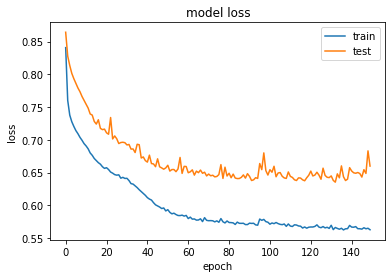

In [0]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [0]:
predictions = autoencoder.predict(X_test_svd)
mse = np.mean(np.power(X_test_svd - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test.values.reshape(1,-1)[0]})
error_df.describe()

,reconstruction_error,true_class
count,74257.000000,74257.000000
mean,0.655850,15.768951
std,15.506325,4.521670
min,0.031104,0.000000
25%,0.089781,14.000000
50%,0.121005,16.000000
75%,0.257092,16.000000
max,1790.583946,39.000000


In [0]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
# _ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)


In [0]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# fraud_error_df = error_df[error_df['true_class'] == 1]
# _ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

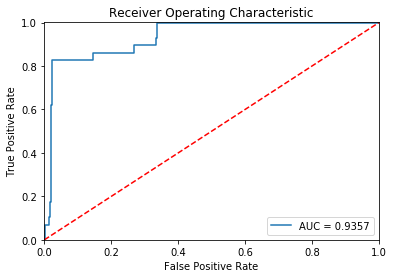

In [0]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error,pos_label=2)
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

Text(0.5, 1.0, 'Recall vs Precision')

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

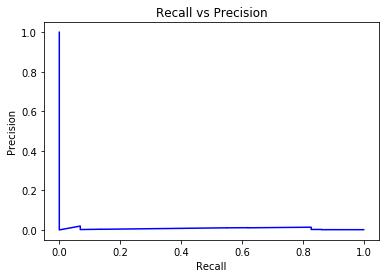

In [0]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error,pos_label=2)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()